In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# fix random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model specification

## Data

In [49]:
batch_size = 128
lr = 3e-4
log_interval = 10
num_epochs = 15

In [50]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

dataset1 = datasets.MNIST("data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("data", train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

In [51]:
indexes = dict()
for index, target in enumerate(dataset1.targets.tolist()):
    if target not in indexes:
        indexes[target] = [index]
    else:
        indexes[target].append(index)

In [52]:
subsampled_indexes = dict()
for i in range(10):
    subsampled_indexes[i] = []
subsampled_data = []
subsampled_target = []
for key, sub_indexes in indexes.items():
    np_sub_indexes = np.random.choice(sub_indexes, 50, replace=False)
    subsampled_indexes[key] = np_sub_indexes
    for index in np_sub_indexes:
        data, target = dataset1.__getitem__(index)
        subsampled_data.append(torch.flatten(data))
        subsampled_target.append(target)
    

subsampled_data = torch.stack(subsampled_data)
subsampled_target = torch.tensor(subsampled_target)
subsampled_data.shape, subsampled_target.shape

(torch.Size([500, 784]), torch.Size([500]))

## Basic optimization loop

In [53]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
            #nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [54]:
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super(DeepAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 784),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [55]:
def train(dataloader, model, criterion, optimizer, num_epochs):
    losses = []
    model.train()

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for x, y in dataloader:
            #x = x.view(-1, 28*28).to(device)
            x = x.view(x.size(0), -1).to(device)
            #print(x.shape)
            x_hat = model(x)

            loss = criterion(x_hat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        loss = running_loss/len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.6f}")
        losses.append(loss)
    
    return losses

In [56]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = train(train_loader, model, criterion, optimizer, num_epochs)

  7%|▋         | 1/15 [00:15<03:39, 15.67s/it]

Epoch 1/15, Loss: 0.990283


 13%|█▎        | 2/15 [00:30<03:18, 15.27s/it]

Epoch 2/15, Loss: 0.800393


 20%|██        | 3/15 [00:46<03:06, 15.55s/it]

Epoch 3/15, Loss: 0.783883


 27%|██▋       | 4/15 [01:02<02:52, 15.68s/it]

Epoch 4/15, Loss: 0.779291


 33%|███▎      | 5/15 [01:18<02:37, 15.73s/it]

Epoch 5/15, Loss: 0.776062


 40%|████      | 6/15 [01:32<02:18, 15.39s/it]

Epoch 6/15, Loss: 0.773482


 47%|████▋     | 7/15 [01:47<02:01, 15.16s/it]

Epoch 7/15, Loss: 0.771556


 53%|█████▎    | 8/15 [02:02<01:45, 15.05s/it]

Epoch 8/15, Loss: 0.766426


 60%|██████    | 9/15 [02:17<01:30, 15.13s/it]

Epoch 9/15, Loss: 0.758022


 67%|██████▋   | 10/15 [02:32<01:15, 15.13s/it]

Epoch 10/15, Loss: 0.751811


 73%|███████▎  | 11/15 [02:47<01:00, 15.06s/it]

Epoch 11/15, Loss: 0.745803


 80%|████████  | 12/15 [03:02<00:44, 14.92s/it]

Epoch 12/15, Loss: 0.741437


 87%|████████▋ | 13/15 [03:17<00:29, 14.82s/it]

Epoch 13/15, Loss: 0.736976


 93%|█████████▎| 14/15 [03:31<00:14, 14.81s/it]

Epoch 14/15, Loss: 0.732791


100%|██████████| 15/15 [03:46<00:00, 15.13s/it]

Epoch 15/15, Loss: 0.730235


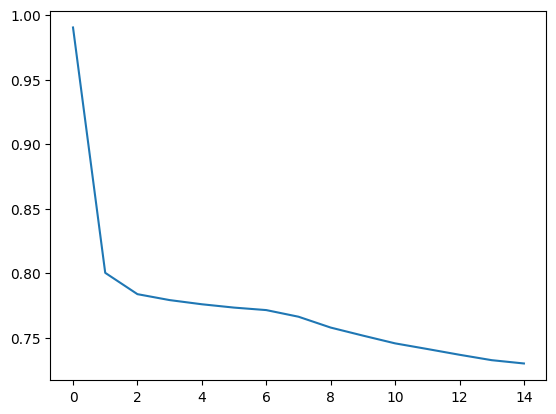

In [57]:
plt.plot(losses)
plt.show()

In [58]:
model.eval()
with torch.no_grad():
    embeddings1 = model.encode(subsampled_data.to(device)).cpu().detach().numpy()

In [59]:
model = DeepAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = train(train_loader, model, criterion, optimizer, num_epochs)

  7%|▋         | 1/15 [00:15<03:32, 15.19s/it]

Epoch 1/15, Loss: 0.986792


 13%|█▎        | 2/15 [00:29<03:12, 14.83s/it]

Epoch 2/15, Loss: 0.791124


 20%|██        | 3/15 [00:44<02:55, 14.60s/it]

Epoch 3/15, Loss: 0.769288


 27%|██▋       | 4/15 [00:58<02:38, 14.41s/it]

Epoch 4/15, Loss: 0.765267


 33%|███▎      | 5/15 [01:12<02:24, 14.43s/it]

Epoch 5/15, Loss: 0.763003


 40%|████      | 6/15 [01:26<02:09, 14.34s/it]

Epoch 6/15, Loss: 0.757219


 47%|████▋     | 7/15 [01:41<01:54, 14.29s/it]

Epoch 7/15, Loss: 0.747629


 53%|█████▎    | 8/15 [01:55<01:41, 14.50s/it]

Epoch 8/15, Loss: 0.739884


 60%|██████    | 9/15 [02:10<01:27, 14.56s/it]

Epoch 9/15, Loss: 0.733600


 67%|██████▋   | 10/15 [02:25<01:12, 14.59s/it]

Epoch 10/15, Loss: 0.728616


 73%|███████▎  | 11/15 [02:40<00:58, 14.67s/it]

Epoch 11/15, Loss: 0.725772


 80%|████████  | 12/15 [02:54<00:43, 14.59s/it]

Epoch 12/15, Loss: 0.723739


 87%|████████▋ | 13/15 [03:09<00:29, 14.60s/it]

Epoch 13/15, Loss: 0.722066


 93%|█████████▎| 14/15 [03:23<00:14, 14.56s/it]

Epoch 14/15, Loss: 0.720479


100%|██████████| 15/15 [03:38<00:00, 14.57s/it]

Epoch 15/15, Loss: 0.718500


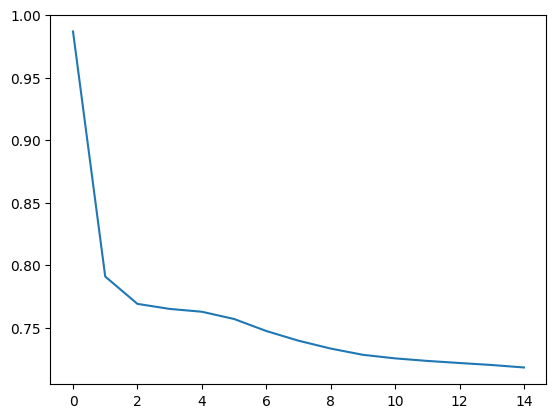

In [60]:
plt.plot(losses)
plt.show()

In [61]:
model.eval()
with torch.no_grad():
    embeddings2 = model.encode(subsampled_data).detach().numpy()

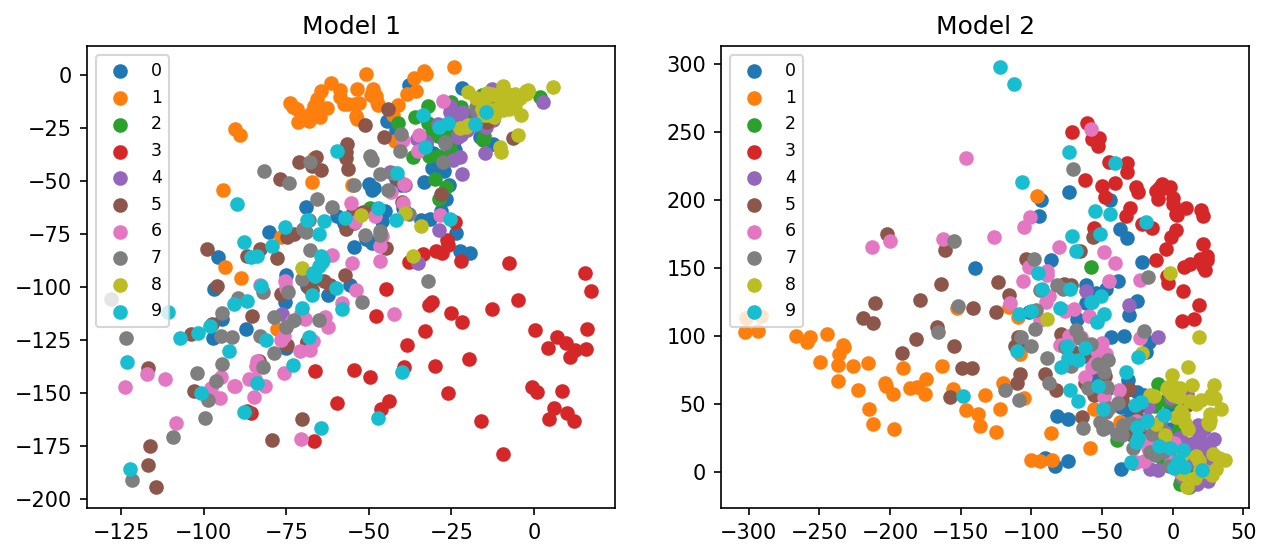

In [62]:
fig, axs = plt.subplots(1, 2, dpi=150, figsize=(10, 4))
cmap = plt.get_cmap("tab10")
axs[0].set_title("Model 1")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[0].scatter(embeddings1[50*i: 50*(i+1), 0], embeddings1[50*i: 50*(i+1), 1], color=color, label=key)
axs[0].legend(fontsize="small")
axs[1].set_title("Model 2")
for i, (key, indexes) in enumerate(subsampled_indexes.items()):
    color = cmap(i / 10)
    axs[1].scatter(embeddings2[50*i: 50*(i+1), 0], embeddings2[50*i: 50*(i+1), 1], color=color, label=key)
axs[1].legend(fontsize="small")
plt.show()